# Development version 17.3.21:1200

In [185]:
import numpy as np

# This method finds the location of all peaks in the full spectrum
# Output (Indices) contains the start index and end index of each peak
# It is assumed that the structure of the data is coherent.

def findPeakIndices(data):

# each peak in 'data' starts and ends with a zero
# so that there are two zeros between each peak
# =============================================

    n = int(round(sum(data.iloc[:,1] == 0)/2)+1) # n is just the upper limit for the number of peaks
    indices = np.zeros([n,2], dtype="uint32")    # true n may be lower

    ii = 0                                       # index for indices
    indices[ii,0] = 0
    i = 1
    while i < len(data):
        if data.iloc[i,1] == 0:     
            if (i+1) == len(data):
                indices[ii,1] = i
            elif data.iloc[i+1,1] == 0:
                indices[ii,1] = i
                ii = ii+1
                i = i+1
                indices[ii,0] = i
        i = i+1
        
# n may be too large, because there are sometimes single zeros within peaks
# therefore, extra indices are cut out
    indices = indices[0:ii+1,:]
    return indices

# KO 6.4. zeros in the beginning and end are now included in indexed peaks
# Another way to save the indices could also be used: 
# add 1 to every indices[ii,0]
# minus 1 from every indices[ii,1]

In [36]:
# Find indices of the different peaks in the data
def XfindPeakIndices(data):   # NOT IN USE
    n = int(round(sum(data[:,1] == 0)/2)+1)
    indices = np.zeros([n,2], dtype="uint32")
    a = False
    ii = 0
    for i in range(len(data[:,1])-1):
        if data[i,1] == 0 and a:
            indices[ii, 1] = i - 1
            if ii != n:
                indices[ii+1, 0] = i
            ii += 1
        a = data[i,1] == 0
    last = n-sum(indices[:,0]>=indices[:,1])
    indices = indices[0:last+1,:]
    indices[last, 1] = len(data[:,0]) - 1
    return indices
#JKo 30.3. version. This is not taken into use

In [184]:
from scipy.optimize import leastsq
import numpy as np
import math

def getMean(peak):
    mu = np.average(peak.iloc[:,0], weights=peak.iloc[:,1])  # painotettu keskiarvo

#    sigma = (mu/280000)/(2*np.log(2))    # was Koli
#    fitfunc  = lambda p, x: p[0]*np.exp(-((x-p[1])/(2*sigma))**2)   # was Koli    

    sigma = mu/(280000*2*np.sqrt(2*np.log(2)))
    fitfunc = lambda p, x: p[0]*np.exp(-0.5*((x-p[1])/sigma)**2)
    errfunc  = lambda p, x, y: (y - fitfunc(p, x))
    init  = [1.0, mu]

    out = leastsq(errfunc, init, args=(peak.iloc[:,0], peak.iloc[:,1]))                 
    c = out[0]
    return sigma, c[1]

# 4.3. JKo, modified 3-5.4. by KO

In [183]:
import numpy as np

def getAllMeans(data):
    indices = findPeakIndices(data)
    peakAreas = getAllAreas(data,indices)
    peakSkews = getAllSkews(data,indices)

    n = len(indices)  
    means = np.zeros(n)
    sigmas = np.zeros(n)
    lefts = np.zeros(n)
    rights = np.zeros(n)
    for i in range(n):
        peak = data.iloc[indices[i,0]:indices[i,1]+1,:]
        sigmas[i], means[i] = getMean(peak)
        lefts[i] = indices[i,0]
        rights[i] = indices[i,1]

    return sigmas, means, peakAreas, peakSkews, lefts, rights


In [ ]:
import numpy as np

# Get all peak means for the data
def XgetAllMeans(peaks):    # NOT IN USE
    indices = findPeakIndices(peaks)
    n = len(indices[:,0])
    means = []
    aa = []
    sigmas = []
    peaki = []
    for i in range(n):
        peak = peaks[indices[i,0]:indices[i,1]+1,:]
        mu, a, sigma = getMeans(peak)
        for ii in range(len(a)):
            means += [mu[ii]]
            aa += [a[ii]]
            sigmas += [sigma[ii]]
            peaki += [i]
    return means, aa, sigmas, peaki

# Not implemented JKO module

In [12]:
import numpy as np

def getArea(peak):
    zum = 0                       # channels may have different widths
    for i in range(1,len(peak)-1):
        zum = zum + peak.iloc[i,1]
    zum = zum * (peak.iloc[len(peak)-1,0]-peak.iloc[1,0])/(len(peak)-2)
    return zum

# KO 4.4.

In [13]:
import pandas as pd
import numpy as np

def getAllAreas(data, indices):
#def getAllAreas(data, peaklist, identified):

    n = len(indices)
    areas = np.zeros(n)
    for i in range(n):
        peak = data.iloc[indices[i,0]:indices[i,1]+1,:]
        areas[i] = getArea(peak)
#    print("all areas ok")
    return areas

# KO 4.4.

In [14]:
import numpy as np
# from scipy.stats import kurtosis, skew
import pandas as pd

def getSkew(peak):
    dta=peak.iloc[:,1]
    skw = dta.skew(axis = 0)
    return skw

# KO 5.4.

In [15]:
import pandas as pd
import numpy as np

def getAllSkews(data, indices):

    n = len(indices)
    skews = np.zeros(n)
    for i in range(n):
        peak = data.iloc[indices[i,0]:indices[i,1]+1,:]
        skews[i] = getSkew(peak)

    return skews

# KO 9.3.

In [188]:
import pandas as pd
import numpy as np

def getPeak(i, peaklist, interest):
    
    # ion index i is here changed to array index ix 
    for j in range(len(peaklist)):
        if peaklist.iloc[j,12] == i:
            ix = j
    if interest:
        print("Peak of interest: ",peaklist.iloc[ix,0])

    left = int(peaklist.iloc[ix,7])
    right = int(peaklist.iloc[ix,8])
    peak = data[left:right+1]
#    print("L R: ",left,right)    
#    print(peak)  # To show tha actual peak data in numbers
    return ix, peak

KO 5.4.

In [189]:
import pandas as pd
import numpy as np
from lmfit.models import GaussianModel

def addGaussians(peaklist):
    
    for i in range(len(peaklist)):  
        index = peaklist.iloc[i,12]
        ix, peak = getPeak(index,peaklist, False)
        df = pd.DataFrame(peak, columns = ['x','y'])
        cc = len(peak.iloc[:,0])
        df['index'] = np.arange(cc).reshape(cc,1)
        df['x'] = peak.iloc[:,0]
        df['y'] = peak.iloc[:,1]
        df.set_index('index', inplace = True)

        model = GaussianModel()
        params = model.guess(df['y'], x=df['x'])
        result = model.fit(df['y'], params, x=df['x'])
        for parname, param in result.params.items():
#            print("%s = %f +/- %f " % (parname, param.value, param.stderr))
            if parname == 'center':
                centerGv = param.value
            if parname == 'sigma':
                sigmaGv = param.value
            if parname == 'fwhm':
                fwhmGv = param.value
                
        peaklist.iloc[i,9] = centerGv
        peaklist.iloc[i,10] = sigmaGv
        peaklist.iloc[i,11] = fwhmGv
        
# KO 5.4.

In [175]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plotPeak(i, peaklist):

    ix, peak = getPeak(i, peaklist, True)
    
    plt.plot(peak.iloc[:,0],peak.iloc[:,1])
    plt.vlines(peaklist.iloc[ix,2],0,max(peak.iloc[:,1]))
    plt.vlines(peaklist.iloc[ix,1],0,max(peak.iloc[:,1]), color = "green")

    plt.legend(["Data","Mean from data","True mean"])
    plt.title(peaklist.iloc[ix,0])
    plt.show()
    
# KO 5.4.

In [190]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

#from lmfit.models import LorentzianModel
from lmfit.models import GaussianModel

def plotGaussian(i, peaklist):
    
    ix, peak = getPeak(i, peaklist, True)  
    
# read the data into a pandas DataFrame, and use the ‘x’ and ‘y’ columns:
# Sata is already in such a dataframe
# dframe = pd.read_csv('peak.csv')

    df = pd.DataFrame(peak, columns = ['x','y'])
    cc = len(peak.iloc[:,0])
    df['index'] = np.arange(cc).reshape(cc,1)
    df['x'] = peak.iloc[:,0]
    df['y'] = peak.iloc[:,1]
#    df['y'] = np.log(peak.iloc[:,1] )  # needs improvement.. log was to handle skewed peaks
    df.set_index('index', inplace = True)
    print(df)

#    model = LorentzianModel()   # was not as good as Gaussian
    model = GaussianModel()
    params = model.guess(df['y'], x=df['x'])
    result = model.fit(df['y'], params, x=df['x'])

# and gives the plot and fitting results below:

    result.plot_fit()
    plt.show()

    print(result.fit_report())

# KO 5.4.

In [187]:
import pandas as pd
import numpy as np

# maxDistance below = 'th' in JKolis's code

def identifyPeaks(data, peaklist, maxDistance):    
    peaklist['observed'] = np.zeros(len(peaklist['mz'])) #2
    peaklist['peak'] = np.zeros(len(peaklist['mz']))     #3
    peaklist['area'] = np.zeros(len(peaklist['mz']))     #4
    peaklist['skew'] = np.zeros(len(peaklist['mz']))     #5
    peaklist['sigma'] = np.zeros(len(peaklist['mz']))    #6
#    peaklist['sigmaJ'] = np.zeros(len(peaklist['mz']))   #7
    peaklist['lefti']  = np.zeros(len(peaklist['mz']))   #7
    peaklist['righti'] = np.zeros(len(peaklist['mz']))   #8
    peaklist['centerG'] = np.zeros(len(peaklist['mz']))   #9
    peaklist['sigmaG']  = np.zeros(len(peaklist['mz']))   #10
    peaklist['fwhmG'] = np.zeros(len(peaklist['mz']))   #11    

#    peakMeans, peakAreas, peakSkews, sigma, sigmaJ, ind = getAllMeans(data)   # THIS TO BE
    sigmas, peakMeans, peakAreas, peakSkews, lefts, rights = getAllMeans(data)
    trueValue = peaklist['mz'].to_numpy()     # get only mz values from the peaklist

    for i in range(len(trueValue)):
        if min(abs(peakMeans - trueValue[i])) < maxDistance:      # there is at least one
            ind = np.argmin(abs(peakMeans - trueValue[i]))
            peaklist.iloc[i,2] = peakMeans[ind]
            peaklist.iloc[i,3] = np.argmin(abs(peakMeans - trueValue[i]))
            peaklist.iloc[i,4] = peakAreas[ind]
            peaklist.iloc[i,5] = peakSkews[ind]
            peaklist.iloc[i,6] = sigmas[ind]
            peaklist.iloc[i,7] = lefts[ind]
            peaklist.iloc[i,8] = rights[ind]

#    peaklist.iloc[i,8] = peaklist.iloc[i,8].to_numpy().astype("uint32")
# np.argmin: Returns the indices of the minimum values along an axis.   

    unidentified = np.linspace(0, len(trueValue)-1, len(trueValue))
    unidentified = unidentified[peaklist['observed'].to_numpy() == 0]
  
    identified = np.linspace(0, len(trueValue)-1, len(trueValue))
    identified = identified[peaklist['observed'].to_numpy() != 0]    

#    unidentified: observed is 0, because it never got a new value

    return peaklist.drop(unidentified)

# Modified by KO 31.3.-6.4.

In [20]:
# Method to read in one spectrum
# You need to give the folder name in this method

# A large number of averaged, denoised spectra are exported from Orbitool into folders
# Exported with Antonio's "all denoised" button

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import glob

def readSpectrum(n):
    dataDir = glob.glob("C:/datascienceproject/raw data/small mass deviation/deno201117n10/*.csv")
    fileName = dataDir[n]
    print("File name: ",fileName)
    df = pd.read_csv(fileName, sep=",")

    print("Shape:      {}, {}".format(*df.shape))
    print()
    data = df.iloc[0:,:2].astype("float64")
    return(data)
    
#fileName = "data/N_minutes_60_N_spectra_10/spectrum_2020-00-17_17_11_07.csv"  # JKo
#return pd.read_csv(fileName).iloc[3:,:2].to_numpy().astype("float64")         # JKo version

# KO method


File name:  C:/datascienceproject/raw data/small mass deviation/deno201117n10\2020-11-17T16-56-28.csv
Shape:      1672, 2

Number of actual recognized peaks:  76
            formula          mz    observed   peak        area      skew  \
1              O3N-   61.988366   61.988376    5.0  471.219190  7.275348   
2          O3N[15]-   62.985401   62.985428    9.0    1.580751  0.962697   
3         O2O[17]N-   62.992584   62.992607   10.0    0.383857  0.818997   
4         O2O[18]N-   63.992613   63.992624   11.0    2.830535  1.183850   
8           C4H5O2-   85.029503   85.029576   14.0    0.027365  0.247550   
9            C2HO4-   88.988032   88.988124   15.0    0.784754  0.690521   
15          C3H3O4-  103.003682  103.003770   16.0    2.934809  0.812670   
17     C2C[13]H3O4-  104.007037  104.007145   17.0    0.090616  0.486498   
20          C2O2F3-  112.985587  112.985646   19.0    0.376735  0.261014   
25          C4H5O4-  117.019332  117.019404   20.0    0.497156  0.789750   
28

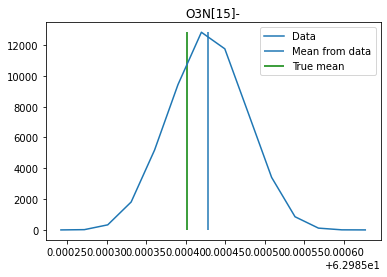

Peak of interest:  C4H5O2-


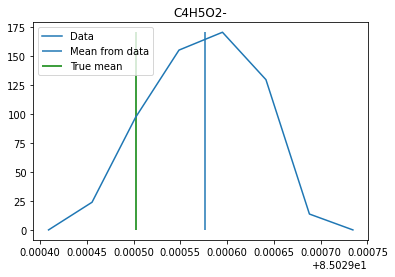

Peak of interest:  C9H14O8N-


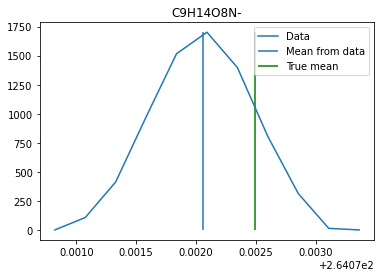

Peak of interest:  C10H14O10N-


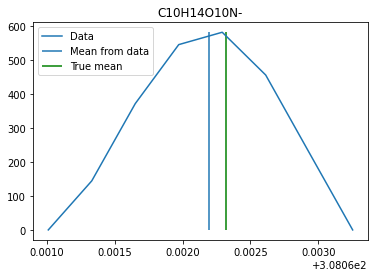

Peak of interest:  O3N[15]-
               x             y
index                         
0      62.985242      0.000000
1      62.985272     17.075324
2      62.985301    329.431572
3      62.985331   1812.231903
4      62.985361   5183.755210
5      62.985390   9432.891558
6      62.985420  12831.607938
7      62.985449  11756.038158
8      62.985479   7594.572567
9      62.985509   3407.785653
10     62.985538    854.007141
11     62.985568    116.417938
12     62.985598      5.014444
13     62.985627      0.000000


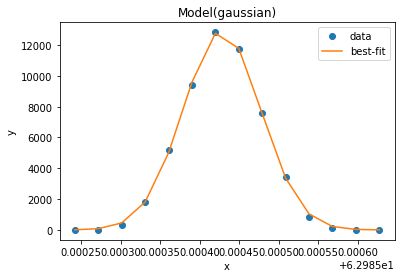

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 9
    # data points      = 14
    # variables        = 3
    chi-square         = 132824.833
    reduced chi-square = 12074.9848
    Akaike info crit   = 134.208208
    Bayesian info crit = 136.125380
[[Variables]]
    amplitude:  1.59152830 +/- 0.00963211 (0.61%) (init = 1.711186)
    center:     62.9854282 +/- 3.4221e-07 (0.00%) (init = 62.98543)
    sigma:      4.9040e-05 +/- 3.4313e-07 (0.70%) (init = 4.445236e-05)
    fwhm:       1.1548e-04 +/- 8.0801e-07 (0.70%) == '2.3548200*sigma'
    height:     12947.0618 +/- 78.4235288 (0.61%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) =  0.577
Peak of interest:  C4H5O2-
               x           y
index                       
0      85.029409    0.000000
1      85.029456   23.816829
2      85.029502   96.801785
3      85.029549  154.834907
4      85.029595 

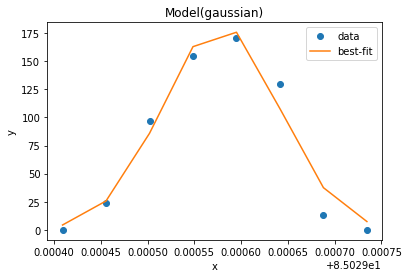

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 9
    # data points      = 8
    # variables        = 3
    chi-square         = 1331.54856
    reduced chi-square = 266.309712
    Akaike info crit   = 46.9172507
    Bayesian info crit = 47.1555753
[[Variables]]
    amplitude:  0.02828314 +/- 0.00202507 (7.16%) (init = 0.03560404)
    center:     85.0295780 +/- 5.2161e-06 (0.00%) (init = 85.02957)
    sigma:      6.1852e-05 +/- 5.2060e-06 (8.42%) (init = 6.972512e-05)
    fwhm:       1.4565e-04 +/- 1.2259e-05 (8.42%) == '2.3548200*sigma'
    height:     182.424005 +/- 13.2115864 (7.24%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) =  0.578
Peak of interest:  C9H14O8N-
                x            y
index                         
0      264.070820     0.000000
1      264.071075   106.284986
2      264.071329   412.924103
3      264.071583   972.471198
4 

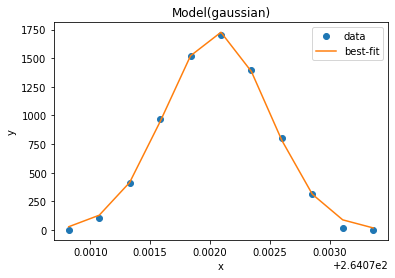

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 11
    # variables        = 3
    chi-square         = 9185.45749
    reduced chi-square = 1148.18219
    Akaike info crit   = 80.0022969
    Bayesian info crit = 81.1959827
[[Variables]]
    amplitude:  1.87129074 +/- 0.02588479 (1.38%) (init = 1.947769)
    center:     264.072058 +/- 6.8879e-06 (0.00%) (init = 264.072)
    sigma:      4.3093e-04 +/- 6.8877e-06 (1.60%) (init = 0.0003816057)
    fwhm:       0.00101477 +/- 1.6219e-05 (1.60%) == '2.3548200*sigma'
    height:     1732.38036 +/- 23.9694844 (1.38%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) =  0.578


C:\Users\kojal\anaconda3\envs\orbitool\lib\site-packages\ipykernel_launcher.py:60: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


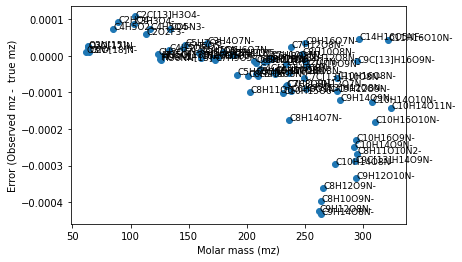

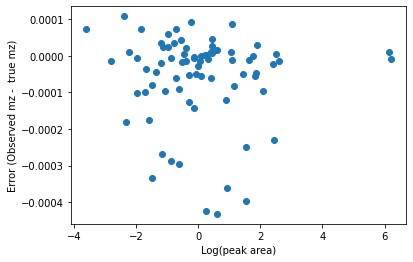

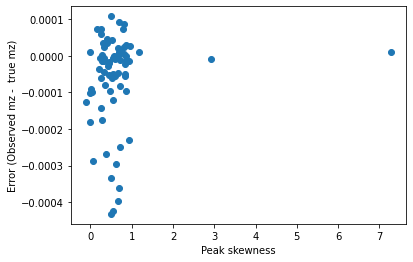


If skewness is less than -1 or greater than 1, the distribution is highly skewed.
If skewness is between -1 and -0.5 or between 0.5 and 1, the distribution is moderately skewed.
If skewness is between -0.5 and 0.5, the distribution is approximately symmetric.

Negative skewness: peak top is to the right from the mean (bigger tail on the left).


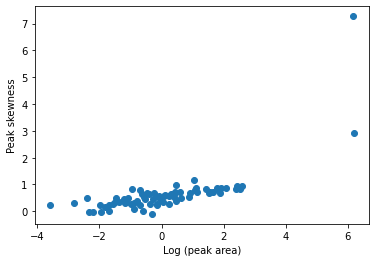

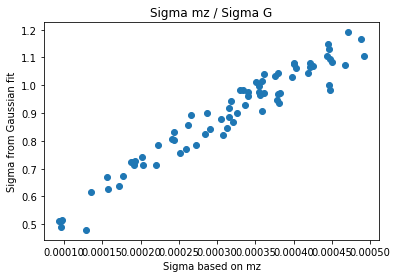

In [197]:
# Main program here

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

data = readSpectrum(2)    # Read the nth file in the folder of spectra
# data = readSpectrum(3)    # Read the nth file in the folder of spectra
# print(data[340:353])      # Just in case if you want to print these

ionFolder = "C:/Users/kojal/pyharj/DSpro/KOionfolder/"  # Has a different structure than JKo ion file
ionFileName = ionFolder + "Allions1ex.csv"
peaklist = identifyPeaks(data, pd.read_csv(ionFileName, sep=","), 0.001)
# Rightmost value just above is the maximum alloved distance between true and observed peak

peaklist['idx'] = peaklist.index.to_numpy()    # Add index value into column 12

addGaussians(peaklist)

#peaklist.iloc[i,5] = peakSkews[ind]


print("Number of actual recognized peaks: ",len(peaklist))
pd.set_option('display.max_rows', len(peaklist))
print(peaklist)   # Helps to find the number of the peak of interest
pd.reset_option('display.max_rows')



# Plot any ion of interest: first parameter indicates the ion number

plotPeak(2,peaklist)
plotPeak(8,peaklist)
plotPeak(215,peaklist)
plotPeak(269,peaklist)

# Plot any ion peak with Gaussian fit

plotGaussian(2, peaklist)
plotGaussian(8, peaklist)
plotGaussian(215, peaklist)


# Plot some interesting graphs

xmz = peaklist['mz']
ydiff = peaklist.iloc[:,2]-peaklist.iloc[:,1]
#nam = peaklist.iloc[:,3].astype(int) # this idea not working yet, so:
names = peaklist.iloc[:,0]
pit = len(xmz)

y = ydiff[:pit]
x = xmz[:pit]
fig = plt.figure()
plt.scatter(x,y)

# To see the names of compounds in the graph, uncomment these lines:

k = names[:pit]
ax = fig.add_subplot(111)   # subplot not working as it should
for i,j,k in zip(x,y,k):
    ax.annotate(str(k),xy=(i+0.4,j), fontsize = 9)

plt.xlabel("Molar mass (mz)")
plt.ylabel("Error (Observed mz -  true mz)")
#plt.figure(figsize=(3,2))           # not working right
#plt.figure(figsize=(6, 4), dpi=70)  # not working right
plt.show()


#ylogarea = np.log(peaklist.iloc[:,4])
#x = ylogarea[:pit]
x = np.log(peaklist['area'])
y = ydiff[:pit]
fig = plt.figure()
plt.scatter(x,y)

# To see the names of compounds in the graph, uncomment these lines:
#for i,j,k in zip(x,y,k):
#    ax.annotate(str(k),xy=(i+0.4,j), fontsize = 9)

plt.xlabel("Log(peak area)")
plt.ylabel("Error (Observed mz -  true mz)")
plt.show()


x = peaklist['skew']
y = ydiff[:pit]
fig = plt.figure()
plt.scatter(x,y)

# To see the names of compounds in the graph, uncomment these lines:
#for i,j,k in zip(x,y,k):
#    ax.annotate(str(k),xy=(i+0.4,j), fontsize = 9)

plt.xlabel("Peak skewness")
plt.ylabel("Error (Observed mz -  true mz)")
plt.show()

print()
print("If skewness is less than -1 or greater than 1, the distribution is highly skewed.")
print("If skewness is between -1 and -0.5 or between 0.5 and 1, the distribution is moderately skewed.")
print("If skewness is between -0.5 and 0.5, the distribution is approximately symmetric.")
print()
print("Negative skewness: peak top is to the right from the mean (bigger tail on the left).")

x = ylogarea[:pit]
y = xskew[:pit]
fig = plt.figure()
plt.scatter(x,y)

# To see the names of compounds in the graph, uncomment these lines:
#for i,j,k in zip(x,y,k):
#    ax.annotate(str(k),xy=(i+0.4,j), fontsize = 9)

plt.xlabel("Log (peak area)")
plt.ylabel("Peak skewness")
plt.show()


x = peaklist['sigma']
y = peaklist['sigmaG']/peaklist['sigma']
fig = plt.figure()
plt.scatter(x,y)

# To see the names of compounds in the graph, uncomment these lines:
#for i,j,k in zip(x,y,k):
#    ax.annotate(str(k),xy=(i+0.4,j), fontsize = 9)

plt.xlabel("Sigma based on mz")
plt.ylabel("Sigma from Gaussian fit")
plt.title("Sigma mz / Sigma Gaussian fit")
plt.show()

# KOj 19.3. and 3-5.4.

In [342]:
print("")

In [104]:
# example
